# Moodsic — PERCEIVE E2E Flow Demo

This notebook mirrors the tests in `tests/test_perceive_e2e_flow.py` to:
- import packages and load adapters (scene and face)
- run `perceive_once()` on an image with a face and an image without a face
- print scene/face/fused valence-arousal results and auxiliary metrics

Notes:
- Adapters fall back gracefully if dependencies/weights are unavailable.
- Inputs are BGR images (OpenCV).


In [9]:
# Setup: ensure repo root on sys.path for imports from models/utils
import os, sys
from pathlib import Path
repo_root = Path.cwd()
# If notebook is opened from notebooks/, add parent as repo root
if repo_root.name == 'notebooks':
    repo_root = repo_root.parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

import math
import numpy as np
try:
    import cv2
except Exception as e:
    raise RuntimeError(f'OpenCV (cv2) is required to run this demo: {e}')

from utils.runtime_driver import perceive_once
print('Repo root:', repo_root)


Repo root: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO


In [10]:
# Load adapters (best-effort, mirroring test fixtures)
scene_adapter = None
face_processor = None
face_adapter = None

# Scene adapter: CLIP ViT (requires transformers + pretrained weights)
try:
    from models.scene.clip_vit_scene_adapter import SceneCLIPAdapter
    scene_adapter = SceneCLIPAdapter(
        model_name='openai/clip-vit-base-patch32',
        dropout_rate=0.3,
        device='auto',
        tta=3,
    )
    print('SceneCLIPAdapter: OK')
except Exception as e:
    print(f'SceneCLIPAdapter unavailable (transformers/weights/device): {e}')

# Face processor: MediaPipe-based cropper (optional)
try:
    from utils.emonet_single_face_processor import EmoNetSingleFaceProcessor
    face_processor = EmoNetSingleFaceProcessor(min_detection_confidence=0.5, padding_ratio=0.2)
    print('Face processor available:' , getattr(face_processor, 'available', False))
except Exception as e:
    print(f'Face processor unavailable (mediapipe missing?): {e}')

# Face adapter: EmoNet (optional weights from models/emonet/pretrained)
try:
    from models.face.emonet_adapter import EmoNetAdapter
    face_adapter = EmoNetAdapter(
        ckpt_dir='models/emonet/pretrained',
        n_classes=8,
        device='auto',
        tta=3,
        calibration_checkpoint=None,
    )
    print('EmoNetAdapter: OK')
except Exception as e:
    print(f'EmoNetAdapter unavailable (torch/weights/device): {e}')


I0000 00:00:1758555452.899272 15790108 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
W0000 00:00:1758555452.901048 15796210 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
No EmoNet checkpoint found in models/emonet/pretrained; using random initialization.


SceneCLIPAdapter: OK
Face processor available: True
EmoNetAdapter: OK


In [11]:
# Helpers: image loading and pretty printing of results
NO_FACE_IMG = (
    'data/Run_2/Affectionate retiree competition/'
    'Elderly-group-in-museum-1200x800.jpg'
)

WITH_FACE_IMG = (
    'data/Run_2/Accepting adults meeting/'
    'videoblocks-diverse-group-of-multinational-business-people-taking-part-in-'
    'corporate-meeting-bored-african-american-man-yawning-while-other-members-'
    'of-seminar-attentively-listening-speech-and-writing-notes_'
    'rsz1toto3e_thumbnail-1080_01.png'
)

WITH_FACE_MIXED_IMG = (
    'data/Run_1/Affectionate people festival/'
    '1969-woodstock-music-festival-hippies-bill-eppridge-john-dominis-121-57bc3130c2d8b__880.jpg'
)

def load_image(path: str):
    # Accept absolute or relative; if missing, try to locate by basename anywhere in repo
    p = Path(path)
    if not p.exists():
        alt = repo_root / path
        if alt.exists():
            p = alt
        else:
            matches = list(repo_root.rglob(p.name)) if p.name else []
            if matches:
                p = matches[0]
                print(f'[info] image not found at given path; using first match: {p}')
            else:
                print(f'[skip] image not found: {path}')
                return None
    img = cv2.imread(str(p))
    if img is None:
        print(f'[skip] failed to read image: {p}')
        return None
    if img.ndim != 3 or img.shape[2] != 3:
        print('[skip] expecting a 3-channel BGR image')
        return None
    return img

def print_fusion_result(res, label: str = ''):
    if not res:
        print(f'{label} — no result')
        return
    def fmt_pred(p):
        if p is None:
            return 'None'
        return (
            f"V={p.valence:.3f}, A={p.arousal:.3f}, "
            f"varV={(p.var_valence if p.var_valence is not None else float('nan')):.4f}, "
            f"varA={(p.var_arousal if p.var_arousal is not None else float('nan')):.4f}, "
            f"valid={p.valid}"
        )
    scene_s = fmt_pred(res.scene)
    face_s = fmt_pred(res.face)
    fused_s = fmt_pred(res.fused)
    print(f'=== {label} ===')
    print(f'SCENE: {scene_s}')
    print(f'FACE : {face_s}')
    print(f'FUSED: {fused_s}')
    # Extras
    if getattr(res, 'face_bbox', None) is not None:
        print(f'face_bbox={res.face_bbox}, face_score={res.face_score:.3f}')
    if getattr(res, 'stability_variance', None) is not None:
        print(f'stability_variance={res.stability_variance}')
    if getattr(res, 'stability_jitter', None) is not None:
        print(f'stability_jitter={res.stability_jitter}')


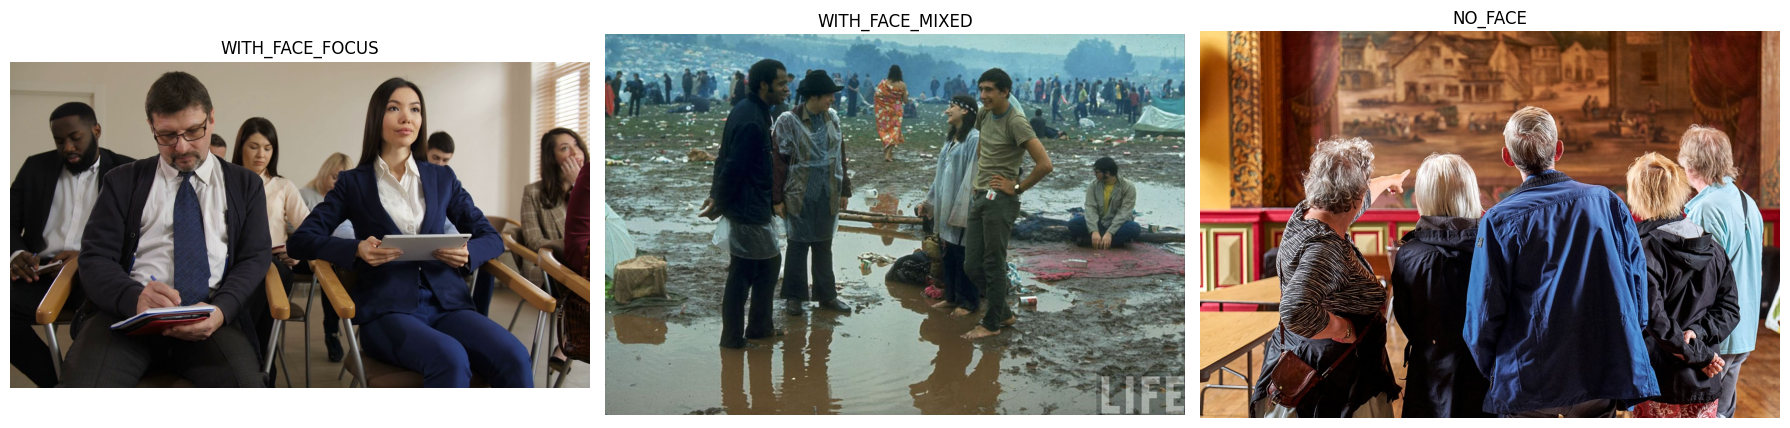

In [12]:
# Preview selected images (WITH_FACE_IMG, WITH_FACE_MIXED_IMG, NO_FACE_IMG)
from pathlib import Path
try:
    _wf = WITH_FACE_IMG
    _wm = WITH_FACE_MIXED_IMG
    _nf = NO_FACE_IMG
except NameError:
    print('Run the helpers cell to define WITH_FACE_IMG/NO_FACE_IMG, then re-run this cell.')
else:
    import matplotlib.pyplot as plt
    def _load_any(path: str):
        p = Path(path)
        if not p.exists():
            alt = repo_root / path
            if alt.exists():
                p = alt
            else:
                matches = list(repo_root.rglob(p.name)) if p.name else []
                if matches:
                    p = matches[0]
                else:
                    print(f"[skip] not found: {path}")
                    return None
        img = cv2.imread(str(p))
        if img is None:
            print(f"[skip] failed to read: {p}")
        return img
    img_wf = _load_any(_wf)
    img_wm = _load_any(_wm)
    img_nf = _load_any(_nf)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for ax, img, title in zip(axes, [img_wf, img_wm, img_nf], ['WITH_FACE_FOCUS', 'WITH_FACE_MIXED', 'NO_FACE']):
        if img is None:
            ax.axis('off'); ax.set_title(f"{title} (missing)")
        else:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax.axis('off'); ax.set_title(title)
    plt.tight_layout()


=== WITH_FACE_FOCUS ===
SCENE: V=-0.293, A=-0.001, varV=0.0171, varA=0.0704, valid=True
FACE : V=0.057, A=0.012, varV=0.0000, varA=0.0000, valid=True
FUSED: V=0.037, A=0.011, varV=0.0009, varA=0.0010, valid=True
face_bbox=(388, 59, 371, 370), face_score=0.112


I0000 00:00:1758555453.426632 15790108 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
W0000 00:00:1758555453.427697 15796231 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


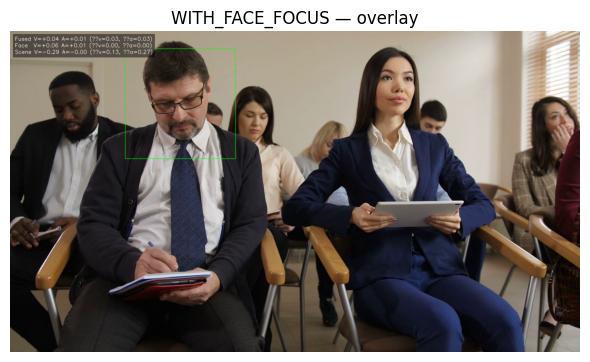

In [13]:
# 1) Image WITH a face (FOCUS) — run perceive_once and print results
img = load_image(WITH_FACE_IMG)
if img is not None:
    res = perceive_once(
        img,
        scene_predictor=scene_adapter,
        face_processor=face_processor,
        face_expert=face_adapter,
        scene_tta=3,
        face_tta=3,
    )
    print_fusion_result(res, label='WITH_FACE_FOCUS')
    # Draw overlay with face bbox and predictions if OpenCV available
    try:
        from utils.fusion_overlay import draw_fusion_overlay
        import matplotlib.pyplot as plt
        over = draw_fusion_overlay(img, res)
        plt.figure(figsize=(6, 5))
        plt.imshow(cv2.cvtColor(over, cv2.COLOR_BGR2RGB))
        plt.axis('off'); plt.title('WITH_FACE_FOCUS — overlay')
        plt.tight_layout()
    except Exception as _e:
        print(f'[info] overlay unavailable: {_e}')
else:
    print('[skip] WITH_FACE_FOCUS image missing; cannot run this cell.')


=== WITH_FACE_MIXED ===
SCENE: V=-0.650, A=0.220, varV=0.0077, varA=0.0537, valid=True
FACE : V=0.000, A=0.000, varV=nan, varA=nan, valid=False
FUSED: V=-0.650, A=0.220, varV=0.0077, varA=0.0537, valid=True


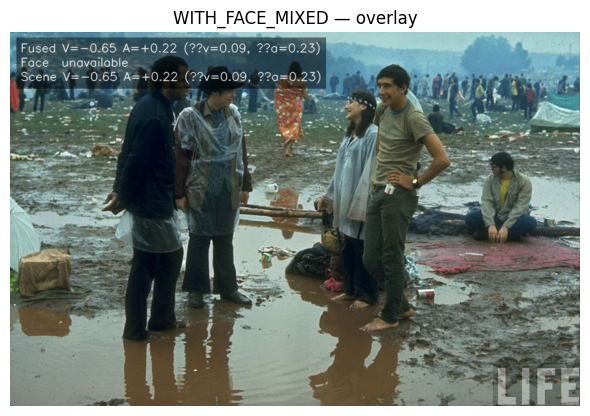

In [14]:
# 1b) Image WITH a face — MIXED variant
img_mixed = load_image(WITH_FACE_MIXED_IMG)
if img_mixed is not None:
    res_mixed = perceive_once(
        img_mixed,
        scene_predictor=scene_adapter,
        face_processor=face_processor,
        face_expert=face_adapter,
        scene_tta=3,
        face_tta=3,
    )
    print_fusion_result(res_mixed, label='WITH_FACE_MIXED')
    # Draw overlay with face bbox and predictions if OpenCV available
    try:
        from utils.fusion_overlay import draw_fusion_overlay
        import matplotlib.pyplot as plt
        over_m = draw_fusion_overlay(img_mixed, res_mixed)
        plt.figure(figsize=(6, 5))
        plt.imshow(cv2.cvtColor(over_m, cv2.COLOR_BGR2RGB))
        plt.axis('off'); plt.title('WITH_FACE_MIXED — overlay')
        plt.tight_layout()
    except Exception as _e:
        print(f'[info] overlay unavailable: {_e}')
else:
    print('[skip] WITH_FACE_MIXED image missing; cannot run this cell.')


In [15]:
# Compare fusion modes on the WITH_FACE_FOCUS image: variance-weighted vs fixed weights
if 'img' in globals() and img is not None:
    # Variance-weighted (current default)
    res_vw = perceive_once(
        img,
        scene_predictor=scene_adapter,
        face_processor=face_processor,
        face_expert=face_adapter,
        scene_tta=3,
        face_tta=3,
        use_variance_weighting=True,
    )
    print_fusion_result(res_vw, label='WITH_FACE_FOCUS — variance_weighted')

    # Fixed weights (ignores variance and blends by scene_weight/face_weight)
    res_fb = perceive_once(
        img,
        scene_predictor=scene_adapter,
        face_processor=face_processor,
        face_expert=face_adapter,
        scene_tta=3,
        face_tta=3,
        use_variance_weighting=False,
        scene_weight=0.6,
        face_weight=0.4,
    )
    print_fusion_result(res_fb, label='WITH_FACE_FOCUS — fixed_weights 60/40')
else:
    print('[skip] WITH_FACE_FOCUS image missing; cannot run comparison.')


=== WITH_FACE_FOCUS — variance_weighted ===
SCENE: V=-0.218, A=0.451, varV=0.0425, varA=0.1289, valid=True
FACE : V=0.057, A=0.012, varV=0.0000, varA=0.0000, valid=True
FUSED: V=0.050, A=0.015, varV=0.0010, varA=0.0010, valid=True
face_bbox=(388, 59, 371, 370), face_score=0.112
=== WITH_FACE_FOCUS — fixed_weights 60/40 ===
SCENE: V=-0.144, A=0.533, varV=0.0029, varA=0.0936, valid=True
FACE : V=0.057, A=0.012, varV=0.0000, varA=0.0000, valid=True
FUSED: V=-0.064, A=0.325, varV=nan, varA=nan, valid=True
face_bbox=(388, 59, 371, 370), face_score=0.112


In [16]:
# 2) Image with NO face — run perceive_once and print results
img_nf = load_image(NO_FACE_IMG)
if img_nf is not None:
    res_nf = perceive_once(
        img_nf,
        scene_predictor=scene_adapter,
        face_processor=face_processor,
        face_expert=face_adapter,
        scene_tta=3,
        face_tta=1,
    )
    print_fusion_result(res_nf, label='NO_FACE')
else:
    print('[skip] NO_FACE image missing; cannot run this cell.')


=== NO_FACE ===
SCENE: V=-0.620, A=0.565, varV=0.0141, varA=0.0105, valid=True
FACE : V=0.000, A=0.000, varV=nan, varA=nan, valid=False
FUSED: V=-0.620, A=0.565, varV=0.0141, varA=0.0105, valid=True
